# 포트폴리오 최적화

CAPM 을 배우며 궁금했던 내용을 코드로 구현해본다. (질문의 구체화)

## correlation metric을 믿을 수 있나요? 

portfolio correlation, 

- expected return > 0 이면서 corr < 0 인 경우는 현실에선 찾기 좀 어렵다. 
- 둘 다 증가하는데 corr 낮은 것은 어떤 조건을 만족해야 하는거지? 
    - 아예 자산군 달라서 commodity와 stock 이 corr 낮은 것은 의미있는 것이지만
    - 단순히 corr이라는 metric의 한계로 인해 corr이 낮을 수도 있지 않을까? 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

둘 다 수익률은 계속 양수라 증가하는데, 

단순히 오르는 t 시점이 달라서 corr이 낮게 나올 수 있다. 

겨우 day 1 만큼만 선행하는 주식인 것임. 이러면 corr = -1 나온다. 

하지만 이걸 진짜 corr 낮은 것이라 볼 수 있을까? 이런 corr을 믿고 분산했다고 할 수 있나? 

In [2]:
stock_return_1 = [.01, .05, .01, .05, .01, .05, .01, .05, .01, .05] # 둘은 무지 비슷하게 움직이지만, day 1 만큼만 선행/후행한다. 
stock_return_2 = [.05, .01, .05, .01, .05, .01, .05, .01, .05, .01]

df = pd.DataFrame(
    {'stock_1': stock_return_1,
     'stock_2': stock_return_2
    }
)

df

,stock_1,stock_2
0,0.01,0.05
1,0.05,0.01
2,0.01,0.05
3,0.05,0.01
4,0.01,0.05
5,0.05,0.01
6,0.01,0.05
7,0.05,0.01
8,0.01,0.05
9,0.05,0.01


In [3]:
def cum_return(df):
    return (1 + df).cumprod()

<Axes: >

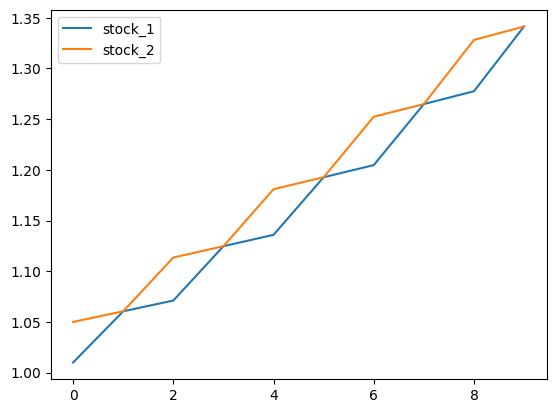

In [4]:
cum_return(df).plot()

In [5]:
df.corr()

,stock_1,stock_2
stock_1,1.0,-1.0
stock_2,-1.0,1.0


In [6]:
df['stock_1'] = df['stock_1'].shift(1) # 만약 선행하지 않으면 둘은 완벽하게 같이 움직인다. corr=1

In [7]:
df

,stock_1,stock_2
0,NaN,0.05
1,0.01,0.01
2,0.05,0.05
3,0.01,0.01
4,0.05,0.05
5,0.01,0.01
6,0.05,0.05
7,0.01,0.01
8,0.05,0.05
9,0.01,0.01


In [8]:
df.corr()

,stock_1,stock_2
stock_1,1.0,1.0
stock_2,1.0,1.0


<Axes: >

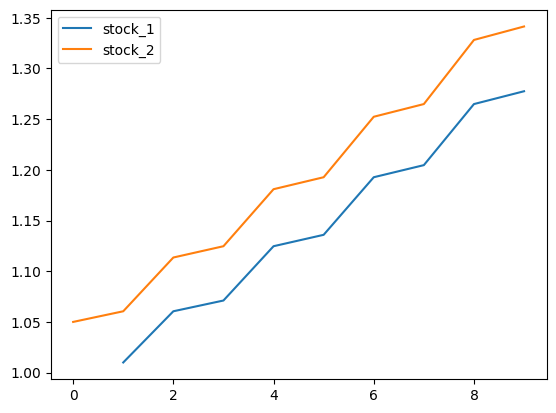

In [9]:
cum_return(df).plot()

이런 상황에서 기계적으로 pairwise pearson correlation을 믿기는 어려워 보인다. 

좀 더 robust correlation을 위한 방법이 없을까? 

1. rolling mean을 써서 smooth out 시킨다. 
2. window를 늘린다. (daily --> weekly --> monthly)
3. pearson corr 대신 다른 correlation metric을 쓴다????? 
    - spearman corr (rank 기반으로 scale을 없앰)
    - ....

이런 다른 alternative corr을 써도 portfolio theory 유지되나?

    최현수 교수님 왈, 우리는 corr이 주어졌다고 가정하고 하기 때문에 corr의 추정 자체는 또 다른 story이다. 
    대체 metric을 써도 우리가 이야기하는 efficient frontier mean-variance optimization은 성립할 것이라고 하심. 

## 특정 corr을 가지는 fake data를 생성

예시를 위해 특정 corr 값을 만족시키는 fake data를 생성하는 함수를 만들고 싶었다. 

막막헀는데, ChatGPT가 기가막히게 짜줌. 

촐레스키 분해를 썼다는데 내가 이 부분 잘 이해를 못해서 이해가 필요하다. 

In [10]:
import numpy as np
import pandas as pd

def generate_fake_stock_data(num_data_points, desired_correlation):
    # Step 1: Generate initial random returns for two stocks
    returns_stock1 = np.random.normal(0, 0.05, num_data_points)
    returns_stock2 = np.random.normal(0, 0.05, num_data_points)
    
    # Step 2: Calculate the covariance matrix based on the desired correlation
    covariance_matrix = np.array([[0.05**2, desired_correlation * 0.05 * 0.05],
                                  [desired_correlation * 0.05 * 0.05, 0.05**2]])
    
    # Step 3: Perform Cholesky decomposition to transform initial returns
    L = np.linalg.cholesky(covariance_matrix)
    initial_returns = np.vstack((returns_stock1, returns_stock2))
    correlated_returns = L.dot(initial_returns)
    
    # Step 4: Create a DataFrame to store the correlated returns
    data = pd.DataFrame(correlated_returns.T, columns=['Stock1', 'Stock2'])
    
    return data


In [11]:

# Example usage:
num_points = 250  # Number of data points
desired_corr = 0.6  # Desired correlation coefficient
fake_data = generate_fake_stock_data(num_points, desired_corr)
print(fake_data.head())


     Stock1    Stock2
0  0.000753 -0.002367
1 -0.001589 -0.000327
2 -0.002107 -0.000842
3 -0.000060  0.001227
4  0.005210  0.003957


In [12]:
fake_data.corr()

,Stock1,Stock2
Stock1,1.000000,0.593529
Stock2,0.593529,1.000000
